**Setup and Configuration**

In [1]:
# ===============================
# 📦 1. Setup and Configuration
# ===============================
!pip install -q timm
import os
import json
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import timm

# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

In [ ]:
!pip install gdown

import gdown

url = ''

output = 'fathomnet'

gdown.download(url, output, quiet=False)

!unzip /kaggle/working/fathomnet -d /kaggle/working/fathomnet_unzipped

Downloading...
From (original): https://drive.google.com/uc?id=1ptdvy-EAT4IFtnvD1ZGDgRRhEigN1hyU
From (redirected): https://drive.google.com/uc?id=1ptdvy-EAT4IFtnvD1ZGDgRRhEigN1hyU&confirm=t&uuid=5056b33a-5302-4591-b6ef-0b510d1c235f
To: /kaggle/working/fathomnet
100%|██████████| 1.25G/1.25G [00:04<00:00, 271MB/s]


Archive:  /kaggle/working/fathomnet
   creating: /kaggle/working/fathomnet_unzipped/.ipynb_checkpoints/
   creating: /kaggle/working/fathomnet_unzipped/test_data/
   creating: /kaggle/working/fathomnet_unzipped/train_data/
  inflating: /kaggle/working/fathomnet_unzipped/dataset_train.json  
  inflating: /kaggle/working/fathomnet_unzipped/dataset_test.json  
  inflating: /kaggle/working/fathomnet_unzipped/download.py  
  inflating: /kaggle/working/fathomnet_unzipped/requirements.txt  
  inflating: /kaggle/working/fathomnet_unzipped/taxonomy_hierarchy.json  
   creating: /kaggle/working/fathomnet_unzipped/test_data/rois/
  inflating: /kaggle/working/fathomnet_unzipped/test_data/annotations.csv  
  inflating: /kaggle/working/fathomnet_unzipped/test_data/rois/2_3.png  
  inflating: /kaggle/working/fathomnet_unzipped/test_data/rois/2_9.png  
  inflating: /kaggle/working/fathomnet_unzipped/test_data/rois/2_6.png  
  inflating: /kaggle/working/fathomnet_unzipped/test_data/rois/2_14.png  
  in

**Load Data and Taxonomy Info**

In [3]:
# ==================================
# 📂 2. Load Data and Taxonomy Info
# ==================================
DATA_DIR = "/kaggle/working/fathomnet_unzipped"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "/kaggle/working/fathomnet_unzipped/train_data/rois")
TEST_IMG_DIR = os.path.join(DATA_DIR, "/kaggle/working/fathomnet_unzipped/test_data/rois")

train_df = pd.read_csv(os.path.join(DATA_DIR, "/kaggle/working/fathomnet_unzipped/train_data/annotations.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "/kaggle/working/fathomnet_unzipped/test_data/annotations.csv"))
print("Train:", len(train_df), "Test:", len(test_df))

# Load taxonomy hierarchy
with open("/kaggle/working/fathomnet_unzipped/taxonomy_hierarchy.json") as f:
    taxonomy_data = json.load(f)

# Validate and fill taxonomy
ranks = ["kingdom", "phylum", "class", "order", "family", "genus", "species"]

def fix_missing(tax, label):
    for i, rank in enumerate(ranks):
        if tax.get(rank) in [None, "Unknown"]:
            parent_rank = ranks[i - 1] if i > 0 else "root"
            parent = tax.get(parent_rank, "root")
            tax[rank] = f"{parent}_{rank}_unknown"
    return tax

for label in taxonomy_data:
    taxonomy_data[label] = fix_missing(taxonomy_data[label], label)

# Build a flattened label encoder for each rank
from collections import defaultdict

rank_to_label = {r: set() for r in ranks}
for tax in taxonomy_data.values():
    for r in ranks:
        rank_to_label[r].add(tax[r])
rank_to_label = {r: sorted(list(v)) for r, v in rank_to_label.items()}
rank_to_id = {r: {v: i for i, v in enumerate(vs)} for r, vs in rank_to_label.items()}


Train: 23699 Test: 788


**Preprocess Labels and Images**

In [4]:
# ==================================
# 🧹 3. Preprocess Labels and Images
# ==================================

def encode_taxonomy(label):
    tax = taxonomy_data[label]
    return [rank_to_id[r][tax[r]] for r in ranks]

train_df["encoded"] = train_df["label"].apply(encode_taxonomy)

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class MarineDataset(Dataset):
    def __init__(self, df, image_dir, transform):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

        # Fix paths in the dataframe
        self.df['path'] = self.df['path'].apply(
            lambda x: os.path.basename(x)  # Extract just the filename
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Use only the filename and join with correct directory
        img_path = os.path.join(self.image_dir, os.path.basename(row["path"]))
        image = default_loader(img_path)
        image = self.transform(image)
        label = torch.tensor(row["encoded"], dtype=torch.long)
        return image, label

train_split, val_split = train_test_split(train_df, test_size=0.1, random_state=42)
train_dataset = MarineDataset(train_split, TRAIN_IMG_DIR, transform_train)
val_dataset = MarineDataset(val_split, TRAIN_IMG_DIR, transform_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


**Define Model Architecture**

In [5]:
# ===============================
# 🧠 4. Define Model Architecture
# ===============================
class HierarchicalClassifier(nn.Module):
    def __init__(self, backbone="efficientnet_v2_s", hidden=512):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=True, num_classes=0, global_pool="avg")
        in_features = self.backbone.num_features
        self.classifiers = nn.ModuleDict({
            r: nn.Linear(in_features, len(rank_to_label[r])) for r in ranks
        })

    def forward(self, x):
        features = self.backbone(x)
        outputs = {r: self.classifiers[r](features) for r in ranks}
        return outputs


**Define Hierarchical Taxonomic Loss**

In [6]:
# ===================================
# 📉 5. Define Hierarchical Taxonomic Loss
# ===================================
def hierarchical_loss(outputs, labels):
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    for i, r in enumerate(ranks):
        total_loss += loss_fn(outputs[r], labels[:, i])
    return total_loss / len(ranks)


In [7]:
'''import timm
print(timm.list_models("efficientnet*", pretrained=True))'''


'import timm\nprint(timm.list_models("efficientnet*", pretrained=True))'

**Training and Validation**

In [7]:
# ===========================
# 🚂 6. Training and Validation
# ===========================
model = HierarchicalClassifier(backbone="efficientnetv2_rw_s.ra2_in1k").to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
early_stop_counter = 0
best_val_loss = float("inf")

for epoch in range(15):
    # Training
    model.train()
    train_loss = 0
    train_correct = [0] * len(ranks)  # Track correct predictions per rank
    train_total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = hierarchical_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy for each rank
        for i, rank in enumerate(ranks):
          _, predicted = torch.max(outputs[rank].data, 1)
          train_correct[i] += (predicted == labels[:, i]).sum().item()


        train_total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = [100 * c / train_total for c in train_correct]

    # Validation
    model.eval()
    val_loss = 0
    val_correct = [0] * len(ranks)
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = hierarchical_loss(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy for each rank
            for i, rank in enumerate(ranks):
              _, predicted = torch.max(outputs[rank].data, 1)
              val_correct[i] += (predicted == labels[:, i]).sum().item()

            val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = [100 * c / val_total for c in val_correct]

    scheduler.step()

    # Print metrics
    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    for i, rank in enumerate(ranks):
        print(f"{rank} Train Acc: {train_acc[i]:.2f}% | Val Acc: {val_acc[i]:.2f}%")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        early_stop_counter += 1
        if early_stop_counter >= 3:
            print("Early stopping.")
            break

model.safetensors:   0%|          | 0.00/96.5M [00:00<?, ?B/s]


Epoch 1
Train Loss: 1.0404 | Val Loss: 0.4343
kingdom Train Acc: 98.84% | Val Acc: 99.66%
phylum Train Acc: 79.37% | Val Acc: 92.15%
class Train Acc: 75.38% | Val Acc: 89.58%
order Train Acc: 66.93% | Val Acc: 85.86%
family Train Acc: 62.33% | Val Acc: 82.28%
genus Train Acc: 60.38% | Val Acc: 80.84%
species Train Acc: 59.00% | Val Acc: 79.28%

Epoch 2
Train Loss: 0.3474 | Val Loss: 0.3641
kingdom Train Acc: 99.58% | Val Acc: 99.70%
phylum Train Acc: 93.86% | Val Acc: 94.39%
class Train Acc: 91.90% | Val Acc: 91.77%
order Train Acc: 87.62% | Val Acc: 87.55%
family Train Acc: 85.23% | Val Acc: 85.27%
genus Train Acc: 83.82% | Val Acc: 83.92%
species Train Acc: 82.59% | Val Acc: 82.49%

Epoch 3
Train Loss: 0.2041 | Val Loss: 0.3242
kingdom Train Acc: 99.78% | Val Acc: 99.49%
phylum Train Acc: 96.70% | Val Acc: 94.73%
class Train Acc: 95.37% | Val Acc: 92.74%
order Train Acc: 92.53% | Val Acc: 89.16%
family Train Acc: 90.76% | Val Acc: 86.54%
genus Train Acc: 89.69% | Val Acc: 85.11%
spe

KINGDOM  - Predicted: Animalia | Ground Truth: Animalia
PHYLUM   - Predicted: Chordata | Ground Truth: Chordata
CLASS    - Predicted: Chordata_class_unknown | Ground Truth: Chordata_class_unknown
ORDER    - Predicted: Scorpaeniformes | Ground Truth: Scorpaeniformes
FAMILY   - Predicted: Sebastidae | Ground Truth: Sebastidae
GENUS    - Predicted: Sebastes | Ground Truth: Sebastes
SPECIES  - Predicted: Sebastes diploproa | Ground Truth: Sebastes diploproa


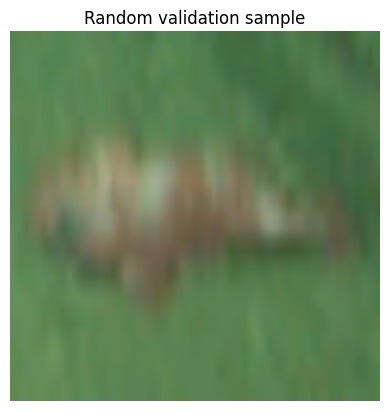

In [8]:
import random
from PIL import Image

# Pick a random sample
idx = random.randint(0, len(val_dataset) - 1)
image, label = val_dataset[idx]

# Unsqueeze and move to device
image_tensor = image.unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(image_tensor)

# Decode prediction and ground truth
softmax = nn.Softmax(dim=1)
for i, rank in enumerate(ranks):
    pred_idx = softmax(outputs[rank]).argmax().item()
    true_idx = label[i].item()
    pred_label = list(rank_to_id[rank].keys())[list(rank_to_id[rank].values()).index(pred_idx)]
    true_label = list(rank_to_id[rank].keys())[list(rank_to_id[rank].values()).index(true_idx)]
    print(f"{rank.upper():<8} - Predicted: {pred_label} | Ground Truth: {true_label}")

# Show the image
plt.imshow(image.permute(1, 2, 0).cpu().numpy())
plt.title("Random validation sample")
plt.axis("off")
plt.show()


**Inference with Confidence Fallback**

In [12]:
print(test_df.columns)


Index(['path', 'label'], dtype='object')


In [16]:
# =====================================
# 🧠 7. Inference with Confidence Fallback
# =====================================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Softmax + threshold fallback
def predict_with_fallback(logits, threshold=0.5):
    softmax = nn.Softmax(dim=1)
    predictions = {}
    for r in ranks[::-1]:  # start from species up to kingdom
        probs = softmax(logits[r])
        conf, pred = probs.max(dim=1)
        predictions[r] = (conf, pred)
        if (conf > threshold).all():
            return r, pred
    return "kingdom", predictions["kingdom"][1]  # fallback worst case

# Predict test set
test_images = []
annotation_ids = test_df["path"].tolist()
for roi_path in tqdm(test_df["path"]):
    img_path = os.path.join("/kaggle/working/fathomnet_unzipped/test_data/rois", os.path.basename(roi_path))
    image = default_loader(img_path)
    image = transform_test(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(image)
    level, pred = predict_with_fallback(logits)
    label = list(rank_to_id[level].keys())[list(rank_to_id[level].values()).index(pred.item())]
    test_images.append(label)



/tmp/ipykernel_31/644949469.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))
100%|██████████| 788/788 [00:16<00:00, 47.

**Submission File Generation**

In [17]:
# =================================
# 📄 8. Submission File Generation
# =================================
submission_df = pd.DataFrame({
    "annotation_id": annotation_ids,
    "concept_name": test_images
})
submission_df.to_csv("submission.csv", index=False)
print("✅ Submission file saved as submission.csv")


✅ Submission file saved as submission.csv
